# CMR Parameter Sweep 

1. Setup & Parameters
2. Core Simulation Functions (reusable)
3. Analysis Metrics (reusable)
4. Visualization Functions (reusable)
5. Parameter Sweep Execution
6. Results Visualization

---
## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

---
## 2. Model Parameters

### List Configuration

In [2]:
# List length and presentation order
N = 10
pres_indices = np.random.permutation(N) + 1  # 1-indexed presentation order

# Sequence values (not used in basic CMR, but kept for compatibility)
sequence = np.array([50, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45])

### Retrieval Route Weights

In [ ]:
# Balance between semantic and episodic retrieval routes
sem = 0
episodic = 1

# Normalize to sum to 1
sem_weight = sem / (episodic + sem)
episodic_weight = episodic / (episodic + sem)

### Context Drift Rates

In [4]:
# Encoding drift: how much context changes when each item is presented
# First item causes complete context update; subsequent items cause moderate drift
B_encD = np.array([1.0, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65])

# Base encoding rate (not used when B_encD is specified, but kept for reference)
B_enc = 0.745

### Semantic Matrix

In [5]:
# Orthogonal semantic representation (each item is distinct)
sem_mat = np.eye(N)

### Network Architecture Parameters

In [ ]:
# Pre-existing connection strengths
gamma_fc = 0.581  # Strength of pre-existing feature-context associations
eye_fc = 1 - gamma_fc
eye_cf = 0

# Learning rates during encoding
lrate_fc_enc = gamma_fc  # Feature-to-context learning rate
lrate_cf_enc = 1.0       # Context-to-feature learning rate

# Learning rates during retrieval (no new learning)
lrate_fc_rec = 0.0
lrate_cf_rec = 0.0

### Retrieval dynamics parameters

In [7]:
# Accumulator dynamics (Leaky Competing Accumulator model)
thresh = 1.0         # Threshold for successful retrieval
rec_time = 90000     # Maximum recall period (ms)
dt = 100             # Time step (ms)
tau = 413            # Time constant for accumulation
K = 0.091            # Decay rate
L = 0.375            # Lateral inhibition strength
eta = 0.3699         # Noise standard deviation

# Number of simulations for averaging
n_sims = 1000

### Grid sweep parameters

In [ ]:
# --- base values (held fixed unless swept) ---
BASE_PARAMS = {
    "B_rec": 0.55,
    "gamma_fc": 0.581,
    "eta": 0.3699,          
    "B_encD_scale": 1.0,   
}

# --- grids (sweep one at a time) ---
B_rec_grid     = [0.10, 0.25, 0.40, 0.55, 0.70, 0.85]
gamma_fc_grid  = np.linspace(0.20, 0.90, 8)      
eta_grid       = np.linspace(0.05, 0.60, 8)      

---
## 3. Simulation Functions

Reusable for different parameter sweeps.

In [ ]:
def simulate_single_trial(B_rec, rng, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0, record_diagnostics=False):
    """
    Simulate one encoding-retrieval trial.
    
    Parameters
    ----------
    B_rec : float
        Context drift rate during retrieval
    rng : numpy.random.Generator
        Random number generator for reproducibility
    record_diagnostics : bool
        If True, record cue advantage diagnostics
    
    Returns
    -------
    recalls : array (N,)
        Serial positions recalled (1-indexed, 0 = no recall)
    times : array (N,)
        Retrieval times for each recall
    net_w_fc : array (N, N)
        Feature-to-context weight matrix after encoding
    net_w_cf : array (N, N)
        Context-to-feature weight matrix after encoding
    diagnostics : dict or None
        Cue advantage measurements (if record_diagnostics=True)
    """
    
    # ========== INITIALIZATION ==========
    net_f = np.zeros((N, 1))  # Feature layer activations
    net_c = np.zeros((N, 1))  # Context layer activations
    
    # Initialize weight matrices
    net_w_fc = np.eye(N) * eye_fc
    net_w_cf = np.eye(N) * eye_cf
    
    # ========== ENCODING PHASE ==========
    for item_idx in range(N):
        # Get the item to present (0-indexed)
        feature_idx = pres_indices[item_idx] - 1
        
        # Activate current item in feature layer
        net_f = np.zeros((N, 1))
        net_f[feature_idx] = 1
        
        # Compute context input from features
        net_c_in = net_w_fc @ net_f
        net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))  # Normalize
        
        # Update context using drift dynamics
        c_in, c = net_c_in, net_c
        B = B_encD[item_idx]  # Context drift for this item
        dot = float(c.T @ c_in)
        rho = np.sqrt(1 + (B**2) * ((dot**2) - 1)) - B * dot
        net_c = rho * c + B * c_in
        
        # Update associative weights (Hebbian learning)
        net_w_fc += (net_c @ net_f.T) * lrate_fc_enc
        net_w_cf += (net_f @ net_c.T) * lrate_cf_enc
    
    # ========== RETRIEVAL SETUP ==========
    recalls = np.zeros((N, 1))
    times = np.zeros((N, 1))
    retrieved = np.zeros((N, 1), dtype=bool)
    thresholds = np.ones((N, 1))
    
    # Combined retrieval cue (episodic + semantic routes)
    net_weights = episodic_weight * net_w_cf + sem_weight * sem_mat
    
    time_passed = 0
    recall_count = 0
    
    # Diagnostic tracking
    if record_diagnostics:
        deltas_all = []
        deltas_by_pos = defaultdict(list)
        delta_forward = []
        delta_backward = []
        pending = None
    
    # ========== RETRIEVAL LOOP ==========
    while time_passed < rec_time:
        
        # Compute feature input from current context
        f_in = net_weights @ net_c
        
        # Setup accumulator simulation
        max_cycles = int((rec_time - time_passed) / dt)
        dt_tau = dt / tau
        sq_dt_tau = np.sqrt(dt_tau)
        
        # Pre-generate noise for all cycles
        noise = rng.normal(0, eta * sq_dt_tau, size=(N, max_cycles))
        
        # Lateral inhibition matrix (inhibit all except self)
        eyeI = ~np.eye(N, dtype=bool)
        lmat = eyeI.astype(float) * L
        
        # Initialize accumulators
        x = np.zeros((N, 1))
        K_array = np.ones((N, 1)) * K
        inds = np.arange(N)
        
        crossed = 0
        i = 0
        
        # replace globals with local values:
        eye_fc_local = 1 - gamma_fc_val
        eye_cf_local = 0

        lrate_fc_enc_local = gamma_fc_val
        lrate_cf_enc_local = 1.0
        lrate_fc_rec_local = 0.0
        lrate_cf_rec_local = 0.0

        net_w_fc = np.eye(N) * eye_fc
        net_w_cf = np.eye(N) * eye_cf
       
        # Run accumulator dynamics until threshold crossed or time runs out
        while i < max_cycles and crossed == 0:
            
            # Compute inhibition and decay
            lx = lmat @ x
            kx = K_array * x
            
            # Update accumulator activations
            x = x + ((f_in - kx - lx) * dt_tau + noise[:, i:i+1])
            x[x < 0] = 0  # No negative activations
            
            # Reset previously retrieved items (prevent repetitions)
            reset_these = retrieved & (x >= thresholds)
            x[reset_these] = 0.95 * thresholds[reset_these]
            
            # Check for threshold crossing
            retrievable = ~retrieved
            if np.any(x[retrievable] >= thresholds[retrievable]):
                crossed = 1
                temp_win = x[retrievable] >= thresholds[retrievable]
                temp_ind = inds[retrievable.flatten()]
                winners = temp_ind[temp_win.flatten()]
                
                # Random tiebreaker if multiple items cross simultaneously
                if len(winners) > 1:
                    winners = np.array([rng.choice(winners)])
            
            i += 1
        
        time_passed += i * dt
        
        # ========== PROCESS RETRIEVAL ==========
        if crossed == 1:
            winner = int(winners[0])
            
            # Find serial position of retrieved item
            serial_pos0 = np.where(pres_indices - 1 == winner)[0][0]
            serial_pos1 = serial_pos0 + 1  # 1-indexed
            
            # Record diagnostics if requested
            if record_diagnostics and pending is not None:
                prev_pos0 = pending["serial_pos0"]
                delta_f_prev = pending["delta_f"]
                transition = serial_pos0 - prev_pos0
                
                if transition == 1:
                    delta_forward.append(delta_f_prev)
                elif transition == -1:
                    delta_backward.append(delta_f_prev)
                
                pending = None
            
            # Reactivate retrieved item
            net_f = np.zeros((N, 1))
            net_f[winner] = 1
            
            # Update context based on retrieved item
            net_c_in = net_w_fc @ net_f
            net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))
            
            c_in, c = net_c_in, net_c
            dot = float(c.T @ c_in)
            rho = np.sqrt(1 + (B_rec**2) * ((dot**2) - 1)) - B_rec * dot
            net_c = rho * c + B_rec * c_in
            
            # Update weights (typically zero learning during retrieval)
            net_w_fc += (net_c @ net_f.T) * lrate_fc_rec
            net_w_cf += (net_f @ net_c.T) * lrate_cf_rec
            
            # Record recall
            recall_count += 1
            recalls[recall_count - 1, 0] = serial_pos1
            times[recall_count - 1, 0] = time_passed
            
            # Compute cue advantage diagnostics if needed
            if record_diagnostics:
                left_pos0 = serial_pos0 - 1
                right_pos0 = serial_pos0 + 1
                
                # Check if both neighbors are available
                if 0 <= left_pos0 < N and 0 <= right_pos0 < N:
                    left_item = pres_indices[left_pos0] - 1
                    right_item = pres_indices[right_pos0] - 1
                    
                    if (not retrieved[left_item]) and (not retrieved[right_item]):
                        f_after = (net_weights @ net_c).flatten()
                        delta_f = f_after[right_item] - f_after[left_item]
                        
                        deltas_all.append(delta_f)
                        deltas_by_pos[serial_pos1].append(delta_f)
                        pending = {"serial_pos0": serial_pos0, "delta_f": delta_f}
            
            retrieved[winner] = True
    
    # Compile diagnostics
    diagnostics = None
    if record_diagnostics:
        diagnostics = {
            "deltas_all": deltas_all,
            "deltas_by_pos": dict(deltas_by_pos),
            "delta_forward": delta_forward,
            "delta_backward": delta_backward
        }
    
    return recalls.flatten(), times.flatten(), net_w_fc, net_w_cf, diagnostics

In [ ]:
def run_simulation(B_rec, n_sims=100, seed=2026, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0):
    """
    Run multiple independent trials with the same parameters.
    
    Parameters
    ----------
    B_rec : float
        Context drift rate during retrieval
    n_sims : int
        Number of independent simulations
    seed : int
        Random seed for reproducibility
    
    Returns
    -------
    recall_sims : array (N, n_sims)
        Recall sequences for all simulations
    times_sims : array (N, n_sims)
        Retrieval times for all simulations
    net_w_fc : array (N, N)
        Final feature-to-context weights (from last simulation)
    net_w_cf : array (N, N)
        Final context-to-feature weights (from last simulation)
    """
    rng = np.random.default_rng(seed)
    
    recall_sims = np.zeros((N, n_sims), dtype=int)
    times_sims = np.zeros((N, n_sims), dtype=float)
    
    net_w_fc_last = None
    net_w_cf_last = None
    
    for s in range(n_sims):
        recalls, times, net_w_fc, net_w_cf, _ = simulate_single_trial(
        B_rec=B_rec,
        rng=rng,
        gamma_fc_val=gamma_fc_val,
        eta_val=eta_val,
        B_encD_scale=B_encD_scale,
        record_diagnostics=False
    )
        
        recall_sims[:, s] = recalls.astype(int)
        times_sims[:, s] = times
        
        net_w_fc_last = net_w_fc
        net_w_cf_last = net_w_cf
    
    return recall_sims, times_sims, net_w_fc_last, net_w_cf_last

---
## 4. Analysis Metrics

Functions to compute standard free recall measures.

In [10]:
def compute_spc(recall_sims, N):
    """
    Compute Serial Position Curve.
    
    Measures P(recall) for each serial position.
    
    Parameters
    ----------
    recall_sims : array (N, n_sims)
        Recall sequences (serial positions 1-N, 0 = no recall)
    N : int
        List length
    
    Returns
    -------
    spc : array (N,)
        Probability of recall for each position
    """
    spc = np.zeros(N)
    for j in range(1, N + 1):
        spc[j - 1] = np.mean(np.any(recall_sims == j, axis=0))
    return spc


def compute_pfr(recall_sims, N):
    """
    Compute Probability of First Recall.
    
    Measures P(first recall) for each serial position.
    
    Parameters
    ----------
    recall_sims : array (N, n_sims)
        Recall sequences
    N : int
        List length
    
    Returns
    -------
    pfr : array (N,)
        Probability of first recall for each position
    """
    first = recall_sims[0, :]
    first = first[first > 0]  # Remove trials with no recalls
    
    pfr = np.zeros(N)
    if len(first) > 0:
        for j in range(1, N + 1):
            pfr[j - 1] = np.mean(first == j)
    return pfr


def compute_lag_crp(recall_sims, N):
    """
    Compute opportunity-corrected Lag-CRP.
    
    Conditional Response Probability as a function of lag
    (temporal distance between successive recalls).
    
    Parameters
    ----------
    recall_sims : array (N, n_sims)
        Recall sequences
    N : int
        List length
    
    Returns
    -------
    lag_vals : array
        Lag values (negative = backward, positive = forward)
    crp : array
        Conditional response probabilities for each lag
    """
    max_lag = N - 1
    lag_vals = np.arange(-max_lag, max_lag + 1)
    
    numer = np.zeros(len(lag_vals), dtype=float)  # Actual transitions
    denom = np.zeros(len(lag_vals), dtype=float)  # Possible transitions
    
    lag_to_idx = {L: i for i, L in enumerate(lag_vals)}
    
    for s in range(recall_sims.shape[1]):
        seq = recall_sims[:, s]
        seq = seq[seq > 0].astype(int)  # Remove blanks
        
        if len(seq) < 2:
            continue
        
        recalled = set()
        
        for t in range(len(seq) - 1):
            cur = seq[t]
            nxt = seq[t + 1]
            
            recalled.add(cur)
            remaining = [j for j in range(1, N + 1) if j not in recalled]
            
            # Count all possible transitions from current position
            for j in remaining:
                L = j - cur
                denom[lag_to_idx[L]] += 1
            
            # Count actual transition
            L_obs = nxt - cur
            numer[lag_to_idx[L_obs]] += 1
    
    # Compute conditional probabilities
    crp = np.zeros_like(numer)
    valid = denom > 0
    crp[valid] = numer[valid] / denom[valid]
    
    return lag_vals, crp


def compute_cue_diagnostics(B_rec, n_sims=100, seed=2026):
    """
    Compute neighbor cue advantage diagnostics.
    
    Measures the difference in cue strength between forward (i+1)
    and backward (i-1) neighbors after recalling position i.
    
    Parameters
    ----------
    B_rec : float
        Retrieval drift rate
    n_sims : int
        Number of simulations
    seed : int
        Random seed
    
    Returns
    -------
    diagnostics : dict
        Contains deltas_all, deltas_by_pos, delta_forward, delta_backward
    """
    rng = np.random.default_rng(seed)
    
    deltas_all = []
    deltas_by_pos = defaultdict(list)
    delta_forward = []
    delta_backward = []
    
    for s in range(n_sims):
        _, _, _, _, diag = simulate_single_trial(
            B_rec=B_rec,
            rng=rng,
            record_diagnostics=True
        )
        
        deltas_all.extend(diag["deltas_all"])
        delta_forward.extend(diag["delta_forward"])
        delta_backward.extend(diag["delta_backward"])
        
        for k, v in diag["deltas_by_pos"].items():
            deltas_by_pos[k].extend(v)
    
    return {
        "deltas_all": deltas_all,
        "deltas_by_pos": dict(deltas_by_pos),
        "delta_forward": delta_forward,
        "delta_backward": delta_backward
    }

---
## 5. Visualization Functions

Reusable plotting functions for sweep results.

In [11]:
def plot_spc_sweep(sweep_results, param_grid, param_name="Parameter"):
    """
    Plot Serial Position Curves across parameter values.
    
    Parameters
    ----------
    sweep_results : dict
        Results dictionary from parameter sweep
    param_grid : list
        Parameter values tested
    param_name : str
        Name of parameter for legend
    """
    plt.figure(figsize=(8, 5))
    
    serial_labels = np.arange(1, N + 1)
    
    for param_val in param_grid:
        spc = sweep_results[param_val]["SPC"]
        plt.plot(serial_labels, spc, marker="o", 
                label=f"{param_name}={param_val:.2f}")
    
    plt.title(f"Serial Position Curve across {param_name}")
    plt.xlabel("Serial Position")
    plt.ylabel("P(Recall)")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_pfr_sweep(sweep_results, param_grid, param_name="Parameter"):
    """
    Plot Probability of First Recall across parameter values.
    """
    plt.figure(figsize=(8, 5))
    
    serial_labels = np.arange(1, N + 1)
    
    for param_val in param_grid:
        pfr = sweep_results[param_val]["PFR"]
        plt.plot(serial_labels, pfr, marker="o",
                label=f"{param_name}={param_val:.2f}")
    
    plt.title(f"Probability of First Recall across {param_name}")
    plt.xlabel("Serial Position")
    plt.ylabel("P(First Recall)")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_lag_crp_sweep(sweep_results, param_grid, param_name="Parameter"):
    """
    Plot Lag-CRP curves across parameter values.
    """
    plt.figure(figsize=(8, 5))
    
    for param_val in param_grid:
        recall_sims = sweep_results[param_val]["recall_sims"]
        lag_vals, crp = compute_lag_crp(recall_sims, N)
        
        neg = lag_vals < 0
        pos = lag_vals > 0
        
        # Plot negative lags
        line, = plt.plot(lag_vals[neg], crp[neg], marker="o",
                        label=f"{param_name}={param_val:.2f}")
        
        # Plot positive lags with same color
        plt.plot(lag_vals[pos], crp[pos], marker="o", color=line.get_color())
    
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(f"Lag-CRP across {param_name}")
    plt.xlabel("Lag (next − current)")
    plt.ylabel("CRP(lag)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_cue_advantage_by_position(sweep_results, param_grid, param_name="Parameter"):
    """
    Plot mean cue advantage [f(i+1) - f(i-1)] by serial position.
    """
    plt.figure(figsize=(8, 5))
    
    positions = np.arange(1, N + 1)
    
    for param_val in param_grid:
        diag = sweep_results[param_val]["cue_diag"]
        
        means = []
        for p in positions:
            vals = diag["deltas_by_pos"].get(p, [])
            means.append(np.mean(vals) if len(vals) > 0 else np.nan)
        
        plt.plot(positions, means, marker="o",
                label=f"{param_name}={param_val:.2f}")
    
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(f"Cue Advantage by Position across {param_name}")
    plt.xlabel("Current Serial Position (i)")
    plt.ylabel(r"Mean Cue Advantage: $f(i+1) - f(i-1)$")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_overall_cue_advantage(sweep_results, param_grid, param_name="Parameter"):
    """
    Plot overall mean cue advantage as a function of parameter value.
    """
    plt.figure(figsize=(7, 5))
    
    advantages = []
    for param_val in param_grid:
        diag = sweep_results[param_val]["cue_diag"]
        adv = np.mean(diag["deltas_all"]) if len(diag["deltas_all"]) > 0 else np.nan
        advantages.append(adv)
    
    plt.plot(param_grid, advantages, marker="o", linewidth=2, markersize=8)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(f"Overall Cue Advantage vs {param_name}")
    plt.xlabel(param_name)
    plt.ylabel(r"Mean Cue Advantage: $f(i+1) - f(i-1)$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

---
## 6. Parameter Sweep: Retrieval Drift ($B_{rec}$)

Sweep across different values of retrieval context drift to examine its effect on recall dynamics.

### Define Parameter Grid

In [12]:
# Parameter values to test
B_rec_grid = [0.10, 0.25, 0.40, 0.55, 0.70, 0.85]

# Base seed for reproducibility (incremented for each parameter value)
BASE_SEED = 2026

### Run Parameter Sweep

In [ ]:
sweep_results = {}

for idx, B_rec_val in enumerate(B_rec_grid):
    print(f"  B_rec = {B_rec_val:.2f} ({idx+1}/{len(B_rec_grid)})")
    
    seed = BASE_SEED + idx
    
    # Run main simulation
    recall_sims, times_sims, net_w_fc, net_w_cf = run_simulation(
        B_rec=B_rec_val,
        n_sims=n_sims,
        seed=seed
    )
    
    # Compute metrics
    spc = compute_spc(recall_sims, N)
    pfr = compute_pfr(recall_sims, N)
    lag_vals, lag_probs = compute_lag_crp(recall_sims, N)
    
    # Compute diagnostics (fewer simulations for speed)
    diag = compute_cue_diagnostics(B_rec_val, n_sims=n_sims, seed=seed)
    
    # Store results
    sweep_results[B_rec_val] = {
        "recall_sims": recall_sims,
        "times_sims": times_sims,
        "SPC": spc,
        "PFR": pfr,
        "lag_vals": lag_vals,
        "lag_probs": lag_probs,
        "net_w_fc": net_w_fc,
        "net_w_cf": net_w_cf,
        "cue_diag": diag
    }

Running parameter sweep...
  B_rec = 0.10 (1/6)
  B_rec = 0.25 (2/6)
  B_rec = 0.40 (3/6)
  B_rec = 0.55 (4/6)
  B_rec = 0.70 (5/6)
  B_rec = 0.85 (6/6)

Sweep complete!


---
## 7. Visualize Results

### Serial Position Curves

Higher $B_{rec}$ → more context drift during retrieval → stronger recency effect.

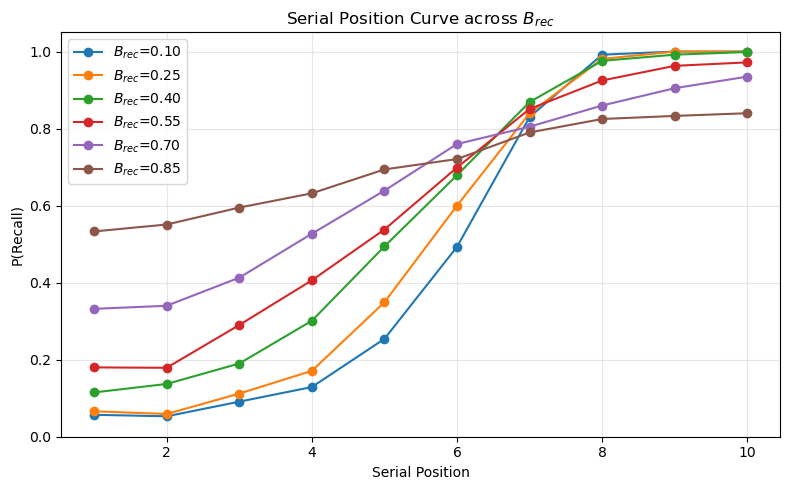

In [14]:
plot_spc_sweep(sweep_results, B_rec_grid, param_name=r"$B_{rec}$")

### Probability of First Recall

Shows which items are most likely to initiate retrieval.

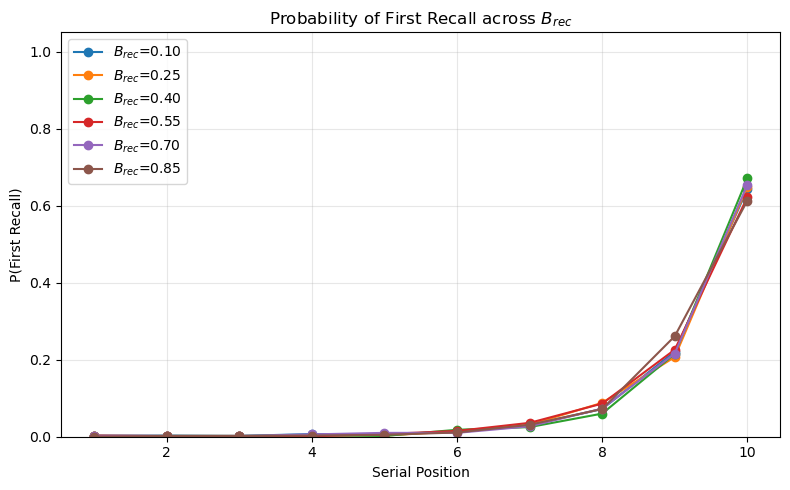

In [15]:
plot_pfr_sweep(sweep_results, B_rec_grid, param_name=r"$B_{rec}$")

### Lag-CRP (Temporal Contiguity)

Measures tendency to recall items that were studied near each other in time.
- **Positive lags**: Forward transitions (i → i+1)
- **Negative lags**: Backward transitions (i → i-1)

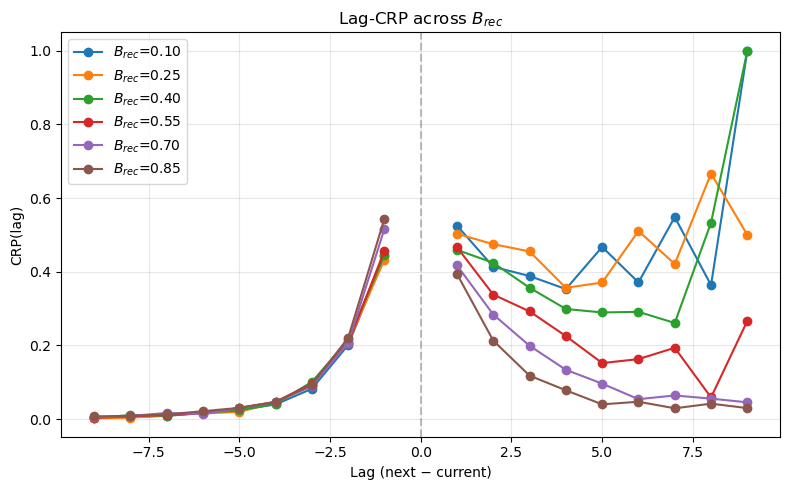

In [16]:
plot_lag_crp_sweep(sweep_results, B_rec_grid, param_name=r"$B_{rec}$")

### Cue Advantage by Position

After recalling position $i$, how much does the retrieval cue favor the forward neighbor $(i+1)$ vs backward neighbor $(i-1)$?

Positive values → forward bias; Negative values → backward bias

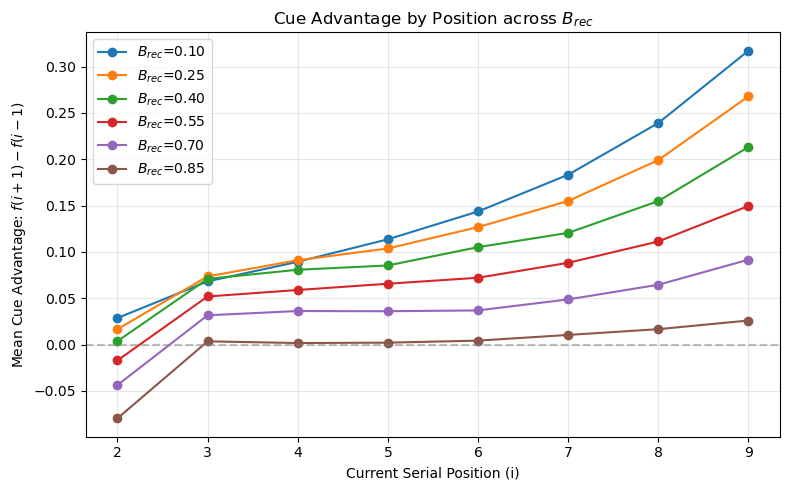

In [17]:
plot_cue_advantage_by_position(sweep_results, B_rec_grid, param_name=r"$B_{rec}$")

### Overall Cue Advantage

Mean cue advantage across all positions as a function of $B_{rec}$.

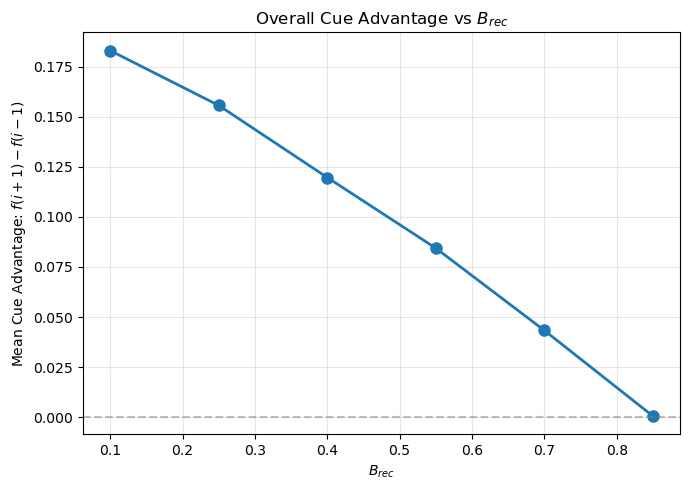

In [18]:
plot_overall_cue_advantage(sweep_results, B_rec_grid, param_name=r"$B_{rec}$")

## To run a different parameter sweep:

1. Modify the parameter grid (e.g., sweep `B_enc`, `sem_weight`, `gamma_fc`)
2. Update the parameter value in `run_simulation()` or `simulate_single_trial()`
3. Use the same visualization functions